C:\Users\Vikhyat\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


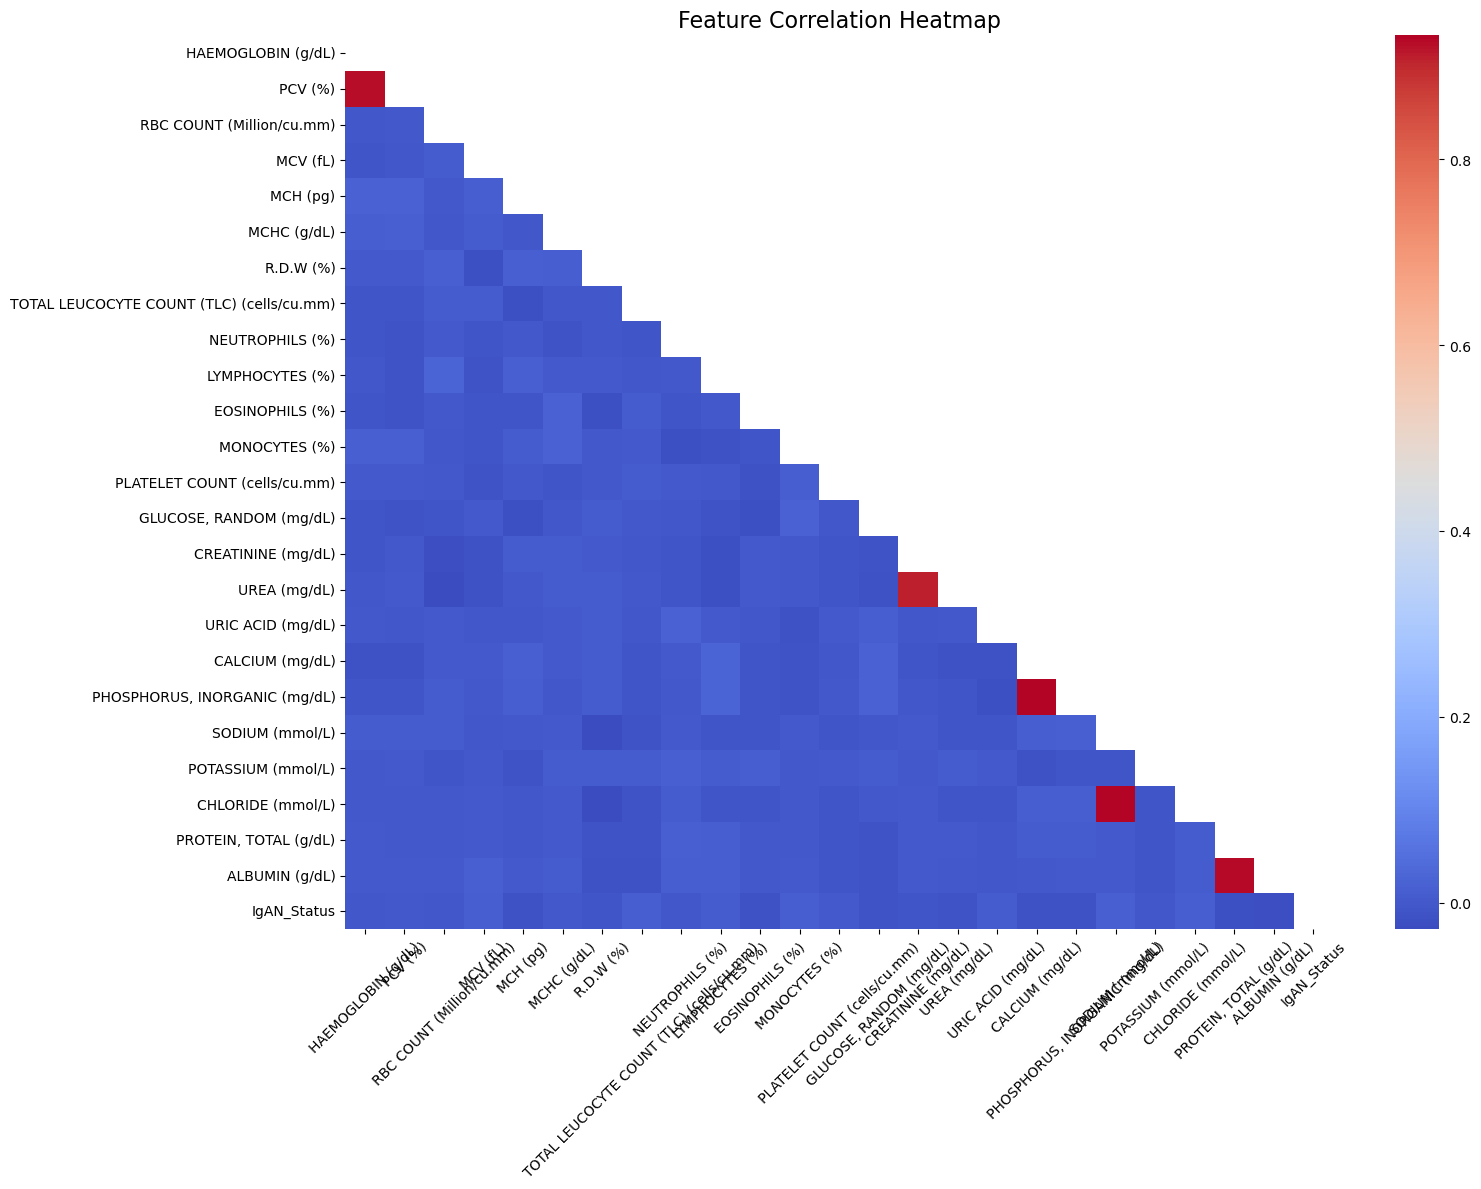

Training Logistic Regression...
Training Random Forest...


C:\Users\Vikhyat\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training SVM...
Training XGBoost...


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,0.522000,0.077495,0.456250,0.132486,0.503584
Random Forest,0.920000,0.000000,0.000000,0.000000,0.501135
SVM,0.725000,0.083333,0.243750,0.124204,0.509096
XGBoost,0.891500,0.086957,0.037500,0.052402,0.488203


<Figure size 1200x600 with 0 Axes>

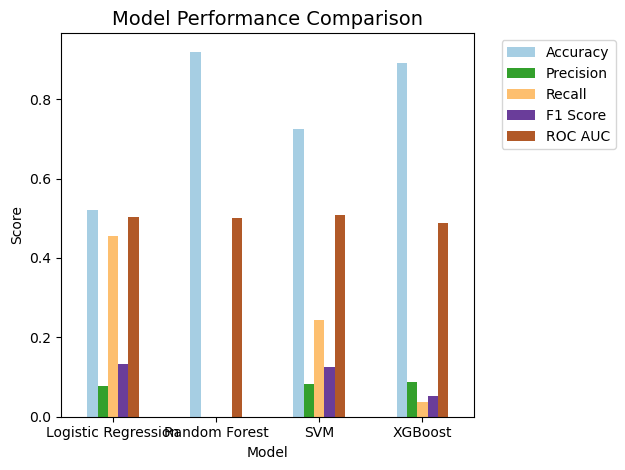

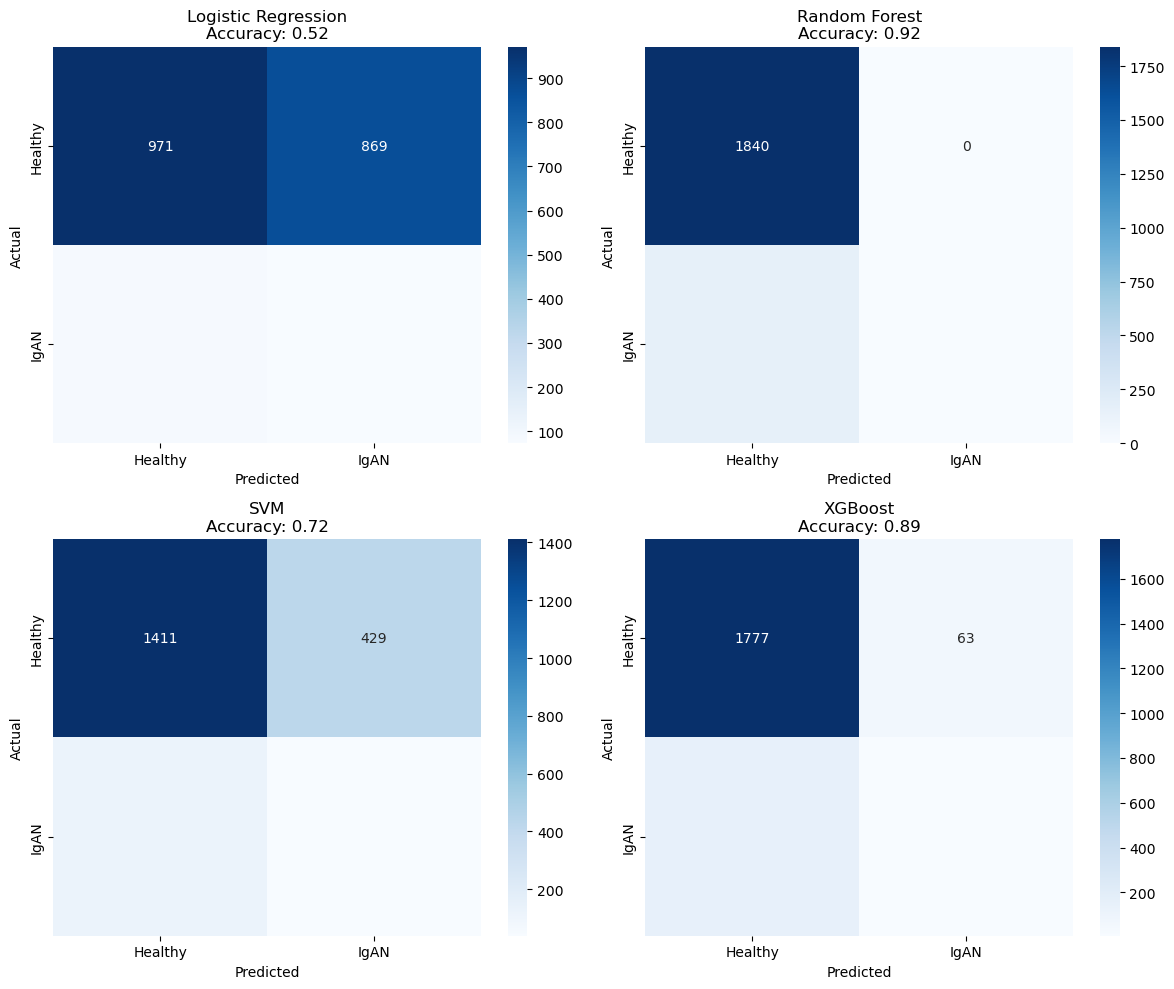

In [1]:
# %% [markdown]
# # IgA Nephropathy Prediction - Model Comparison
# 
# **Objective**: Compare Logistic Regression, Random Forest, SVM, and XGBoost for IgAN prediction

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix)

# %%
# Load and prepare data
df = pd.read_csv('processed_data.csv')
X = df.drop(['Patient ID', 'IgAN_Status'], axis=1)
y = df['IgAN_Status']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# %% [markdown]
# ## 1. Correlation Analysis

# %%
plt.figure(figsize=(16, 12))
corr_matrix = df.drop('Patient ID', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 2. Model Training

# %%
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), 
                            eval_metric='aucpr', random_state=42)
}

# %%
# Train and evaluate models
results = []
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Store metrics
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

# %% [markdown]
# ## 3. Performance Comparison

# %%
# Create results dataframe
results_df = pd.DataFrame(results).set_index('Model')
display(results_df.style.background_gradient(cmap='Blues', axis=0))

# %%
# Plot metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
plt.figure(figsize=(12, 6))
results_df[metrics].plot(kind='bar', colormap='Paired')
plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 4. Confusion Matrices

# %%
# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for (name, model), ax in zip(models.items(), axes.flatten()):
    y_pred = model.predict(X_test)
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Healthy', 'IgAN'], 
                yticklabels=['Healthy', 'IgAN'])
    ax.set_title(f'{name}\nAccuracy: {accuracy_score(y_test, y_pred):.2f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()